# Test and run offline eval for comparison to ground truth values

In [54]:
import os
import cv2
import json
import yaml
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_ubyte
import matplotlib.font_manager as fm
from scipy.stats import linregress

from offline_eval_functions import *

# Import Predictions & Metadata

In [55]:
experiment = 'crop_center_coord'  # define your experiment

In [56]:
#config
config_file_path = f'/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/{experiment}/config/config.yaml'
with open(config_file_path, 'r') as file: cfg = yaml.safe_load(file) # load yaml as cfg

# predictions
root_predictions = f'/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/{experiment}/checkpoints/predictions'
pred_files = [f for f in sorted(os.listdir(root_predictions)) if f.startswith("pred_")]
img_files = [f for f in sorted(os.listdir(root_predictions)) if f.startswith("img_")]

# annotations 
annot_files = f'/mnt/class_data/group2/alexandradigiacomo/dataset/annotations/{experiment}/val.json'
with open(annot_files, 'r') as f:
    annotations = json.load(f)

# metadata
metadata = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/metadata.csv'
metadata_lengths = '/mnt/class_data/group2/alexandradigiacomo/dataset/metadata/sharklengths_metadata.csv' # photog lengths

# export folder
dir_predictions_morphometrics = f'/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/{experiment}/eval/predictions_morphometrics'

In [57]:
# make dataframes - double merging some columns; to be cleaned
df_meta = pd.read_csv(metadata) # metadata from exif
df_meta.rename(columns={'FileName': 'filename'}, inplace=True)

df_meta_len = pd.read_csv(metadata_lengths) # measurements (photogrammetry)
df_meta_len.rename(columns={'FileName': 'filename'}, inplace=True)

# merge
df_meta_full = pd.merge(df_meta_len, df_meta, on=['filename'], how='left')

# build skeleton df
df_skel = process_biometrics(root_predictions, pred_files)

# merge skeleton with metadata
merged_df = pd.merge(df_skel, df_meta_full, on='filename', how='left')

# crop-based pixel reconstruction
crop_size = cfg['crop_size'] # define crop size 
img_size = cfg['image_size'] # define final size
use_custom_crop = cfg['use_custom_crop'] # pull out custom crop option

# photogrammetric conversions
merged_df = reconstruct_pixels_from_crop(merged_df, crop_size, img_size, use_custom_crop)
merged_df = photogrammetric_conversion(merged_df)

# additional functionality
ft_to_cm = 30.48
merged_df['VisualLength_cm'] = merged_df['White.Shark.ID'].apply(
    lambda x: float(x.split('_')[-1]) * ft_to_cm if isinstance(x, str) and x.count('_') >= 2 and x.split('_')[-1].isdigit() else None
)

merged_df['sex'] = merged_df['White.Shark.ID'].apply(
    lambda x: (x.split('_')[-2]) if isinstance(x, str) and x.count('_') >= 2 else None
)

# Compute BSR
merged_df['BSR'] = merged_df['body_span_transf']/merged_df['TL_pixels_skeleton_transf']

# manual BCR
merged_df['BCR'] = merged_df['FrontalSpan_Pixels']/merged_df['TL_Pixels']

# Export final csv

In [58]:
merged_df.to_csv(f'/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/{experiment}/eval/evaluation.csv')

# Visualization 

In [5]:
# build masks list
masks = []
for file in pred_files:
    mask_path = os.path.join(root_predictions, file)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = connect_clean_mask(mask)
    masks.append(mask)  

# build image list
imgs = []
for file in img_files:
    img_path = os.path.join(root_predictions, file)
    img = Image.open(img_path)
    img = np.array(img)
    imgs.append(img)

In [9]:
# export skeleton and cross section predictions 

for i in range(len(masks)): 
    mask = masks[i] # get mask
    img = imgs[i] # get image
    base_name = img_files[i].split('_')[1].split('.')[0]  # get base name
    img_name = f'morphometrics_{base_name}.png' # create image name
    save_path = os.path.join(dir_predictions_morphometrics, img_name) # create save path
    fig = plot_mask_with_skeleton_and_cross_sections(img, mask) # store plot
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.close(fig)

In [10]:
# export plots with line extension

for i in range(len(masks)): 
    mask = masks[i] # get mask
    img = imgs[i] # get image
    base_name = img_files[i].split('_')[1].split('.')[0]  # get base name
    img_name = f'lineextension_{base_name}.png' # create image name
    save_path = os.path.join(dir_predictions_morphometrics, img_name) # create save path
    
    skeleton = create_skeleton(mask)
    src_coords, dst_coords, shortest_path, extended_path = compute_extended_path(skeleton, mask)
    fig = plot_extended_path(extended_path, shortest_path, src_coords, dst_coords, img) # store plot

    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, transparent=True) # save plot
    plt.close(fig)

Sanity check plot

In [26]:
#mask = masks[152]
#mask = masks[151]
#mask = masks[33] # artifact
mask = masks[0] # nose ext
img = imgs[0] # nose ext

#mask = masks[146] # nose extension
#img = imgs[146] # nose extension

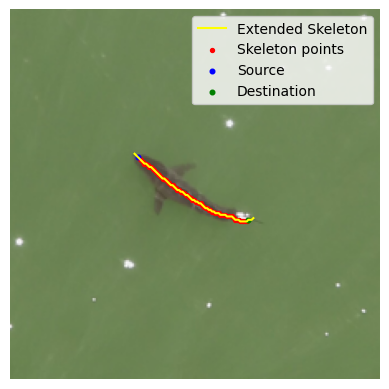

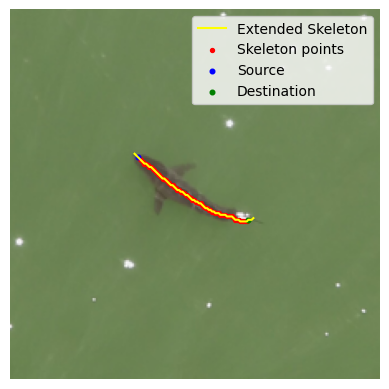

In [27]:
skeleton = create_skeleton(mask)
src_coords, dst_coords, shortest_path, extended_path = compute_extended_path(skeleton, mask)
plot_extended_path(np.array(extended_path), np.array(shortest_path), np.array(src_coords), np.array(dst_coords), img)

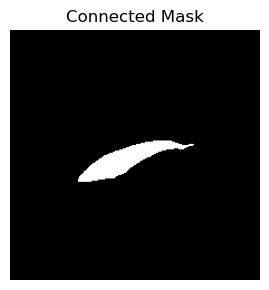

In [21]:
# Display connected mask
plt.figure(figsize=(5, 3))
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.title("Connected Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
mask = masks[97] # pull mask
img = imgs[97] # pull image
skel_plot = create_skeleton(mask) # skeletonize mask

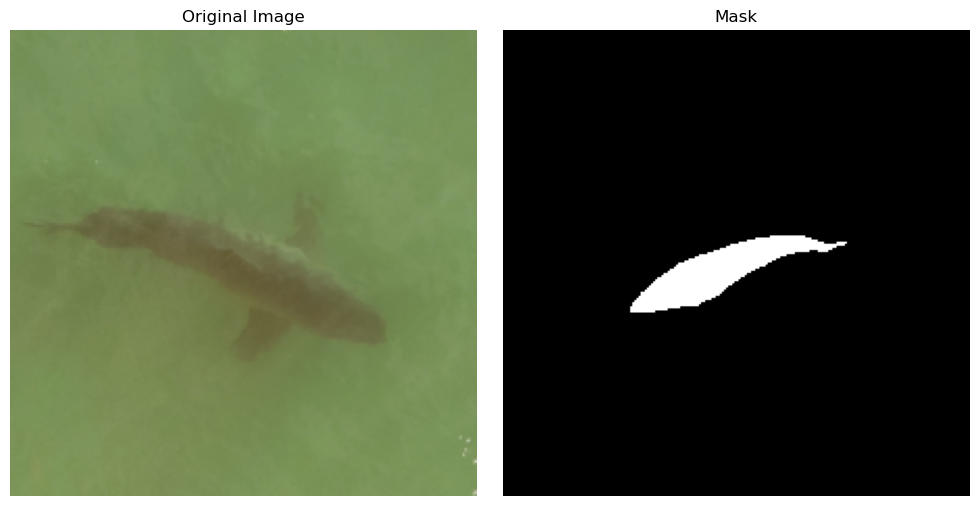

In [22]:
# Example plotting - image and mask side by side
plt.figure(figsize=(10, 5))

# Plot the image (left side)
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')  # Assuming imgs[0] is your image, change index if needed
plt.axis('off')  # Optional: Hide axis for a cleaner look

# Plot the mask (right side)
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')  # Mask as you previously used
plt.axis('off')  # Optional: Hide axis for a cleaner look

plt.tight_layout()  # Adjust the spacing to make the layout cleaner
plt.show()


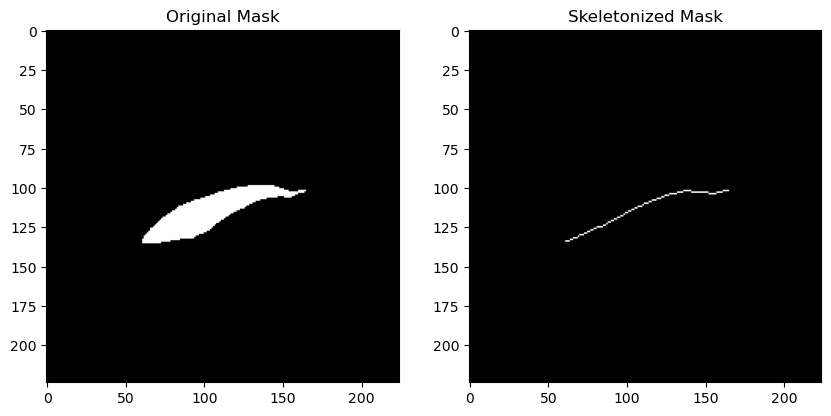

In [23]:
# Example plotting 
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Skeletonized Mask')
plt.imshow(create_skeleton(mask), cmap='gray')

plt.show()

# Plotting Pixels

0.9947715417971563


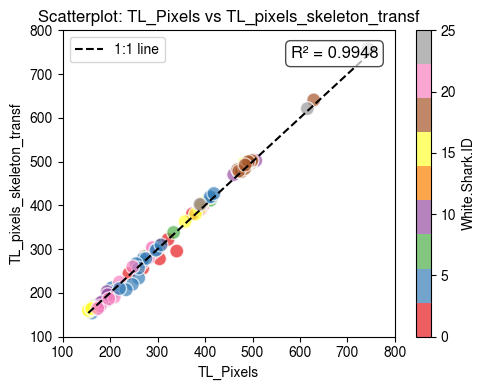

In [70]:
# r2 computation
merged_df_clean = merged_df.dropna(subset=['TL_Pixels', 'TL_pixels_skeleton_transf'])
slope, intercept, r_value, p_value, std_err = linregress(merged_df_clean['TL_Pixels'], merged_df_clean['TL_pixels_skeleton_transf'])
r_squared = r_value ** 2

print(r_squared)
# Color TL:TL plot by White.Shark.ID
white_shark_id_mapping = {id_: idx for idx, id_ in enumerate(merged_df['White.Shark.ID'].unique())}
merged_df['White.Shark.ID_numeric'] = merged_df['White.Shark.ID'].map(white_shark_id_mapping)

# Create scatter plot with color mapping based on White.Shark.ID_numeric
plt.figure(figsize=(5, 4))

# Plot the scatter points, color by the numeric encoded White.Shark.ID
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['White.Shark.ID_numeric'], cmap='Set1', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL_Pixels')
plt.ylabel('TL_pixels_skeleton_transf')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar and legend
plt.colorbar(scatter, label='White.Shark.ID')
plt.legend(loc='upper left')

# Add R² value to the plot (top-right corner)
plt.text(0.95, 0.95, f'R² = {r_squared:.4f}', transform=plt.gca().transAxes, ha='right', va='top', 
         fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round'))


# Adjust layout
plt.tight_layout()

plt.xlim(100, 800)
plt.ylim(100, 800)

# Show plot
plt.show()


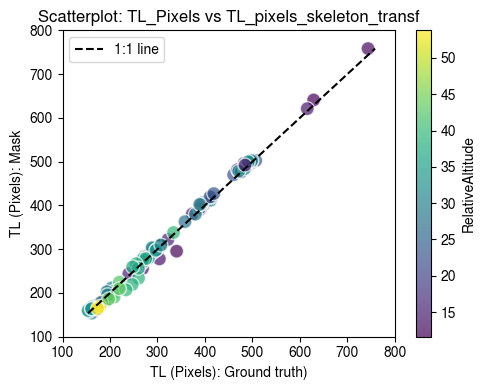

In [72]:
# Color TL:TL plot by relative altitude
plt.figure(figsize=(5, 4))

# Plot the scatter points, color by 'RelativeAltitude'
scatter = plt.scatter(merged_df['TL_Pixels'], merged_df['TL_pixels_skeleton_transf'],
                      c=merged_df['RelativeAltitude_x'], cmap='viridis', s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['TL_Pixels'].min(), merged_df['TL_pixels_skeleton_transf'].min())
max_val = max(merged_df['TL_Pixels'].max(), merged_df['TL_pixels_skeleton_transf'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('TL (Pixels): Ground truth)')
plt.ylabel('TL (Pixels): Mask')
plt.title('Scatterplot: TL_Pixels vs TL_pixels_skeleton_transf')

# Add a colorbar with the label for 'RelativeAltitude'
plt.colorbar(scatter, label='RelativeAltitude')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

plt.xlim(100, 800)
plt.ylim(100, 800)

# Show plot
plt.show()


# Photogrammetric Measurements Comparison

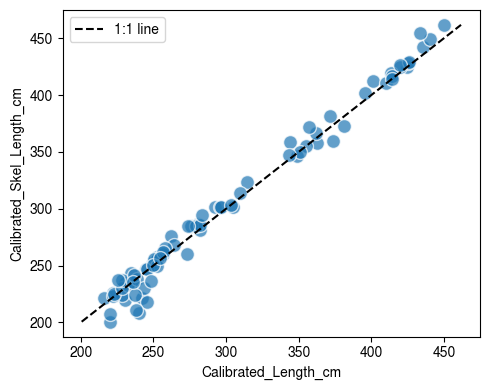

In [73]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(merged_df['Calibrated_Length_cm'], merged_df['Calibrated_Skel_Length_cm'],
                    s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['Calibrated_Length_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['Calibrated_Length_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('Calibrated_Length_cm')
plt.ylabel('Calibrated_Skel_Length_cm')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

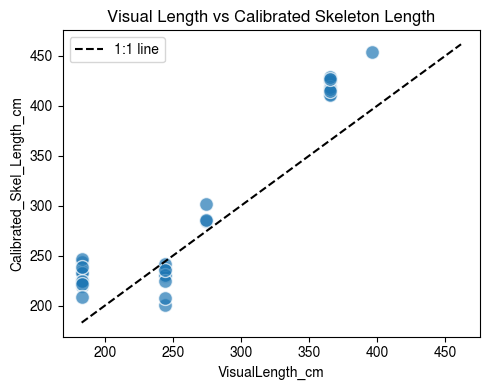

In [74]:
plt.figure(figsize=(5, 4))

scatter = plt.scatter(merged_df['VisualLength_cm'], merged_df['Calibrated_Skel_Length_cm'],
                      s=100, edgecolor='w', alpha=0.7)

# Plot the 1:1 line (where x = y)
min_val = min(merged_df['VisualLength_cm'].min(), merged_df['Calibrated_Skel_Length_cm'].min())
max_val = max(merged_df['VisualLength_cm'].max(), merged_df['Calibrated_Skel_Length_cm'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('VisualLength_cm')
plt.ylabel('Calibrated_Skel_Length_cm')
plt.title('Visual Length vs Calibrated Skeleton Length')

# Add a legend for the 1:1 line
plt.legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Body Condition Comparisons

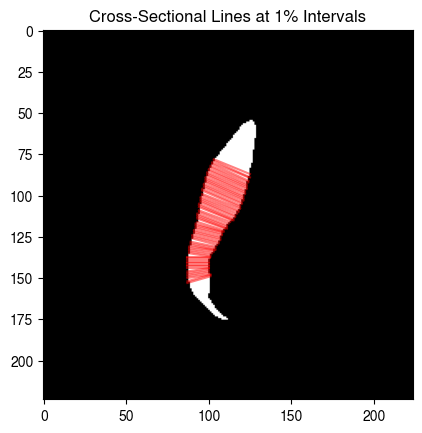

In [75]:
# Example usage
cross_section_points = get_cross_sectional_points(mask)
plot_cross_sections(mask, cross_section_points)

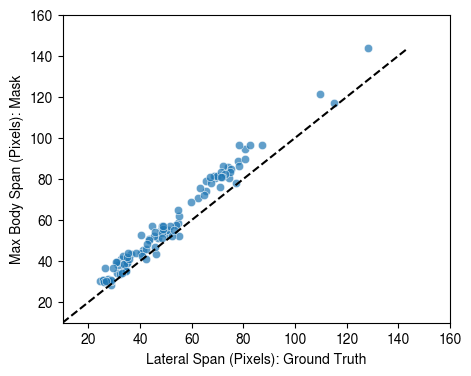

In [78]:
# Set up the plot
plt.figure(figsize=(5, 4))

# Scatter plot for spans
sns.scatterplot(data=merged_df, x='LateralSpan_Pixels', y='body_span_transf', alpha=0.7)

# Add the dashed line (x = y)
plt.plot([0, max(merged_df['LateralSpan_Pixels'].max(), merged_df['body_span_transf'].max())],
         [0, max(merged_df['LateralSpan_Pixels'].max(), merged_df['body_span_transf'].max())],
         'k--', label="x = y")  # 'k--' is the color black with a dashed line style

plt.xlabel('Lateral Span (Pixels): Ground Truth')
plt.ylabel('Max Body Span (Pixels): Mask')

plt.xlim(10,160)
plt.ylim(10,160)

# Show the plot
plt.show()

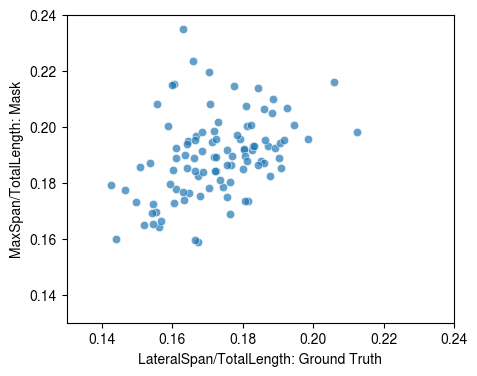

In [79]:
# Set up the plot
plt.figure(figsize=(5, 4))

# Scatter plot for BCR vs. BAI
sns.scatterplot(data=merged_df, x='BCR', y='BSR', alpha=0.7)
plt.xlabel('LateralSpan/TotalLength: Ground Truth')
plt.ylabel('MaxSpan/TotalLength: Mask')

plt.xlim(0.13,0.24)
plt.ylim(0.13,0.24)

# Show the plot
plt.show()

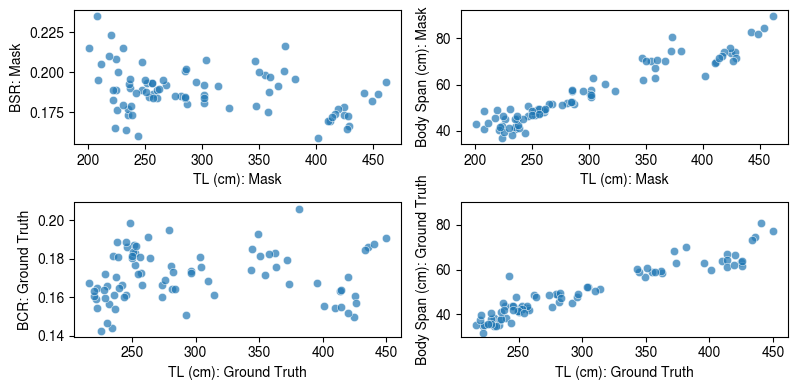

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))

sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='BSR', alpha=0.7, ax=axs[0,0])
axs[0,0].set_xlabel('TL (cm): Mask')
axs[0,0].set_ylabel('BSR: Mask')

sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='Calibrated_body_span_cm', alpha=0.7, ax=axs[0,1])
axs[0,1].set_xlabel('TL (cm): Mask')
axs[0,1].set_ylabel('Body Span (cm): Mask')

sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='BCR', alpha=0.7, ax=axs[1,0])
axs[1,0].set_xlabel('TL (cm): Ground Truth')
axs[1,0].set_ylabel('BCR: Ground Truth')

sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='Calibrated_LS_cm', alpha=0.7, ax=axs[1,1])
axs[1,1].set_xlabel('TL (cm): Ground Truth')
axs[1,1].set_ylabel('Body Span (cm): Ground Truth')
plt.ylim(30,90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



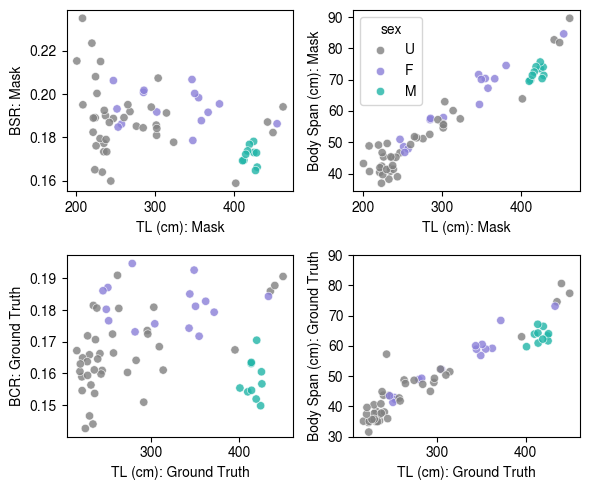

In [81]:
custom_palette = {'M': '#1fb4a7',  # Greenish blue for 'M'
                  'F': '#8a7fd8',  # Lavender for 'F'
                  'U': '#808080'}  # Gray for 'U'
fig, axs = plt.subplots(2, 2, figsize=(6, 5))


# First plot: Calibrated_Skel_Length_cm vs. BSR
sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='BSR', alpha=0.8, ax=axs[0, 0], hue='sex', palette=custom_palette, legend = False)
plt.rcParams["font.family"] = "Nimbus Sans"
axs[0, 0].set_xlabel('TL (cm): Mask')
axs[0, 0].set_ylabel('BSR: Mask')

# Second plot: Calibrated_Skel_Length_cm vs. Calibrated_body_span_cm
sns.scatterplot(data=merged_df, x='Calibrated_Skel_Length_cm', y='Calibrated_body_span_cm', alpha=0.8, ax=axs[0, 1], hue='sex', palette=custom_palette, legend = True)
plt.rcParams["font.family"] = "Nimbus Sans"
axs[0, 1].set_xlabel('TL (cm): Mask')
axs[0, 1].set_ylabel('Body Span (cm): Mask')

# Third plot: Calibrated_Length_cm vs. BCR
sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='BCR', alpha=0.8, ax=axs[1, 0], hue='sex', palette=custom_palette, legend = False)
plt.rcParams["font.family"] = "Nimbus Sans"
axs[1, 0].set_xlabel('TL (cm): Ground Truth')
axs[1, 0].set_ylabel('BCR: Ground Truth')

# Fourth plot: Calibrated_Length_cm vs. Calibrated_LS_cm
sns.scatterplot(data=merged_df, x='Calibrated_Length_cm', y='Calibrated_LS_cm', alpha=0.8, ax=axs[1, 1], hue='sex', palette=custom_palette, legend = False)
plt.rcParams["font.family"] = "Nimbus Sans"
axs[1, 1].set_xlabel('TL (cm): Ground Truth')
axs[1, 1].set_ylabel('Body Span (cm): Ground Truth')

# Set y-axis limit for the fourth plot
axs[1, 1].set_ylim(30, 90)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Residuals Exploration

In [59]:
merged_df.loc[:, 'TL_residuals_pixels'] = (merged_df['TL_pixels_skeleton_transf'] - merged_df['TL_Pixels'])
merged_df.loc[:, 'TL_residuals_cm'] = (merged_df['Calibrated_Skel_Length_cm'] - merged_df['Calibrated_Length_cm'])
merged_df.loc[:, 'TL_residuals_perc'] = (merged_df['TL_residuals_pixels']/merged_df['TL_Pixels'])

merged_df.loc[:, 'G_residuals_pixels'] = (merged_df['body_span_transf'] - merged_df['LateralSpan_Pixels'])
merged_df.loc[:, 'G_residuals_cm'] = (merged_df['Calibrated_body_span_cm'] - merged_df['Calibrated_LS_cm'])
merged_df.loc[:, 'G_residuals_perc'] = (merged_df['G_residuals_pixels']/merged_df['LateralSpan_Pixels'])


In [82]:
df_slim = merged_df[['filename', 'TL_Pixels', 'TL_pixels_skeleton_transf', 'TL_residuals_pixels', 'TL_residuals_perc', 'LateralSpan_Pixels', 'ProximalSpan_Pixels', 'FrontalSpan_Pixels', 'body_span_transf', 'body_span', 'G_residuals_pixels', 'G_residuals_perc']]
df_slim.loc[df_slim['TL_residuals_perc'].abs().sort_values(ascending=False).index].head(5)

,filename,TL_Pixels,TL_pixels_skeleton_transf,TL_residuals_pixels,TL_residuals_perc,LateralSpan_Pixels,ProximalSpan_Pixels,FrontalSpan_Pixels,body_span_transf,body_span,G_residuals_pixels,G_residuals_perc
13,07272023PANB0504.JPG,340.317,295.435753,-44.881247,-0.131881,54.113,41.331,56.002,57.628118,19.209373,3.515118,0.064959
126,11012023PAMB0904.JPG,233.656,207.051432,-26.604568,-0.113862,40.934,36.486,44.036,42.426407,14.142136,1.492407,0.036459
125,11012023PAMB0903.JPG,246.812,219.240940,-27.571060,-0.111709,42.286,40.001,46.517,46.000000,15.333333,3.714000,0.087830
118,10312023PAMB0806.JPG,260.213,233.721795,-26.491205,-0.101806,48.695,35.673,44.353,51.351728,17.117243,2.656728,0.054559
107,10312023PAMB0304.JPG,208.673,190.475907,-18.197093,-0.087204,35.556,27.019,33.515,41.000000,13.666667,5.444000,0.153111


In [67]:
#merged_df.loc[merged_df['TL_residuals_pixels'].abs().sort_values(ascending=False).index].head(5)
#merged_df.loc[merged_df['TL_residuals_perc'].abs().sort_values(ascending=False).index].head(10)
#merged_df.loc[merged_df['G_residuals_pixels'].abs().sort_values(ascending=False).index].head(5)
merged_df.loc[merged_df['G_residuals_perc'].abs().sort_values(ascending=False).index].head(5)

,filename,skeleton_TL,body_area,body_span,Unnamed: 0_x,Label,TL_Pixels,White.Shark.ID,Nickname,TrueLength_ft,...,VisualLength_cm,sex,BSR,BCR,TL_residuals_pixels,TL_residuals_cm,TL_residuals_perc,G_residuals_pixels,G_residuals_cm,G_residuals_perc
165,11302024PAAN0309.JPG,248.872009,3364725,67.862903,NaN,shark,NaN,Unknown 1,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,10132023PAAN0507.JPG,213.639739,1198500,38.937638,287.0,shark,628.892,AN23101304_U_U,NaN,NaN,...,NaN,U,0.182258,0.187746,12.027218,8.425662,0.019124,1.677913,1.175461,0.014573
148,11102024PAAN0203.JPG,147.453201,754545,36.359318,NaN,shark,NaN,Unknown 1,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,12132023PAMB1003.JPG,189.576170,984555,35.929839,481.0,shark,743.494,MB23121302_U_9,NaN,NaN,...,274.32,U,0.189527,0.176989,14.810681,NaN,0.019920,15.563356,NaN,0.121441
141,11072024PAAN0408.JPG,158.517500,783360,34.058773,NaN,shark,NaN,AN24110708_M_U,NaN,NaN,...,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


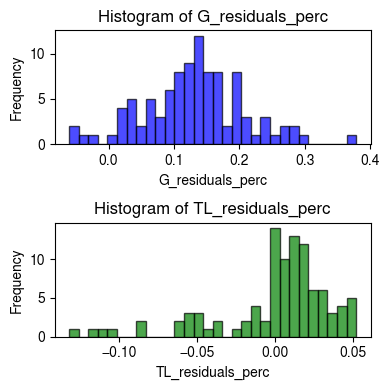

In [62]:
# Assuming 'merged_df' is a DataFrame that contains the columns 'G_residuals_perc' and 'TL_residuals_perc'
plt.figure(figsize=(4, 4))

# Plot for G_residuals_perc
plt.subplot(2, 1, 1)  # (rows, columns, index)
plt.hist(merged_df['G_residuals_perc'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of G_residuals_perc')
plt.xlabel('G_residuals_perc')
plt.ylabel('Frequency')

# Plot for TL_residuals_perc
plt.subplot(2, 1, 2)  # (rows, columns, index)
plt.hist(merged_df['TL_residuals_perc'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of TL_residuals_perc')
plt.xlabel('TL_residuals_perc')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

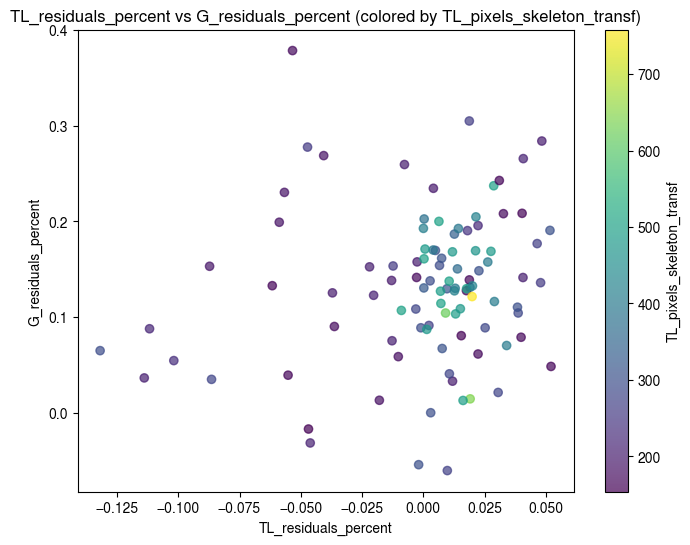

In [63]:
plt.figure(figsize=(8, 6))

# Scatter plot: TL_residuals_pixels vs G_residuals_pixels
scatter = plt.scatter(
    merged_df['TL_residuals_perc'], 
    merged_df['G_residuals_perc'],
    c=merged_df['TL_pixels_skeleton_transf'],  # Color by TL_pixels_skeleton_transf
    cmap='viridis',  # Color map for better visualization (you can change this to any other map)
    alpha=0.7,  # Slight transparency for better visualization
)

# Adding color bar for TL_pixels_skeleton_transf
plt.colorbar(scatter, label='TL_pixels_skeleton_transf')

# Labels and title
plt.xlabel('TL_residuals_percent')
plt.ylabel('G_residuals_percent')
plt.title('TL_residuals_percent vs G_residuals_percent (colored by TL_pixels_skeleton_transf)')
#plt.xlim(-0.15, 0.15)
#plt.ylim(-0.3, 0.45)

# Show the plot
plt.show()